In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

def set_seed(seed=433):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(433)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [11]:
train_df = pd.read_csv('data/DailyDelhiClimateTrain.csv')
test_df = pd.read_csv('data/DailyDelhiClimateTest.csv')

print(f"Training dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

print(f"\nTraining data - First few rows:")
print(train_df.head())

print(f"\nTest data - First few rows:")
print(test_df.head())

print(f"\nColumns in both datasets:")
print(f"Train: {train_df.columns.tolist()}")
print(f"Test: {test_df.columns.tolist()}")

print(f"\nDate ranges:")
print(f"Train: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Test: {test_df['date'].min()} to {test_df['date'].max()}")

Training dataset shape: (1462, 5)
Test dataset shape: (114, 5)

Training data - First few rows:
         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

Test data - First few rows:
         date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333

Columns in both datasets:
Train: ['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']
Test: ['date', 'meantemp', 'humidi

In [12]:
train_data = train_df[['meantemp']].values  # shape (num_samples, 1)
test_data = test_df[['meantemp']].values

# Normalize the data (important for LSTM training)
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 10

X_train, y_train = create_sequences(train_data_scaled, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data_scaled, SEQ_LENGTH)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

print(f"X_train shape: {X_train.shape}")  # (num_sequences, seq_length, 1)
print(f"y_train shape: {y_train.shape}")  # (num_sequences, 1)

X_train shape: torch.Size([1452, 10, 1])
y_train shape: torch.Size([1452, 1])


In [13]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = X_train.to(device)
y_train = y_train.to(device)

In [14]:
# Hyperparameters
input_size = 1         # only 'meantemp'
hidden_size = 64       # number of LSTM hidden units
num_layers = 2         # stacked LSTM layers
output_size = 1        # predict next temperature
num_epochs = 100
batch_size = 32
learning_rate = 0.001

In [15]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [16]:

class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(VanillaLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [17]:
model = VanillaLSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
loss_list = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    loss_list.append(avg_loss)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

Epoch [10/100], Loss: 0.006018
Epoch [20/100], Loss: 0.005032
Epoch [30/100], Loss: 0.003757
Epoch [40/100], Loss: 0.002810
Epoch [50/100], Loss: 0.002741
Epoch [60/100], Loss: 0.003183
Epoch [70/100], Loss: 0.003622
Epoch [80/100], Loss: 0.002796
Epoch [90/100], Loss: 0.003121
Epoch [100/100], Loss: 0.003062


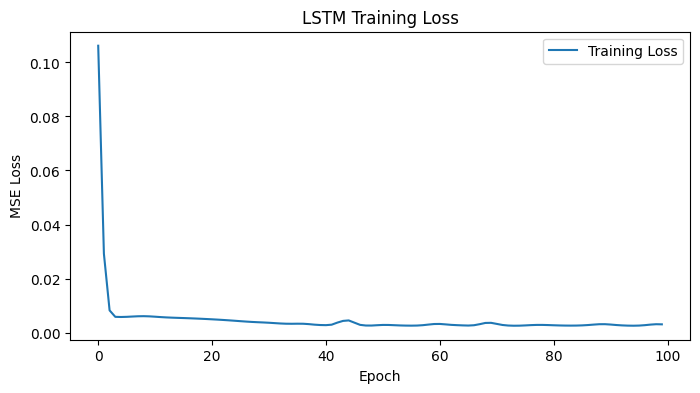

In [19]:
plt.figure(figsize=(8,4))
plt.plot(loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Training Loss')
plt.legend()
plt.show()

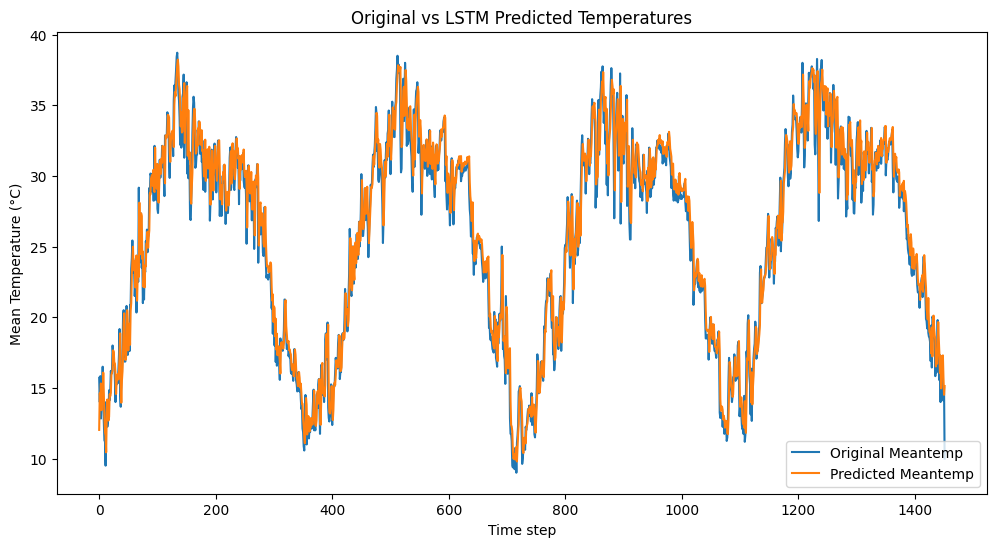

In [20]:
model.eval()

with torch.no_grad():
    train_preds = model(X_train).cpu().numpy()  # predicted values
    y_train_np = y_train.cpu().numpy()

train_preds_original = scaler.inverse_transform(train_preds)
y_train_original = scaler.inverse_transform(y_train_np)

plt.figure(figsize=(12,6))
plt.plot(y_train_original, label='Original Meantemp')
plt.plot(train_preds_original, label='Predicted Meantemp')
plt.xlabel('Time step')
plt.ylabel('Mean Temperature (°C)')
plt.title('Original vs LSTM Predicted Temperatures')
plt.legend()
plt.show()

### Transformer Model

In [21]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, output_size=1, seq_length=10):
        super(TimeSeriesTransformer, self).__init__()
        self.seq_length = seq_length
        self.d_model = d_model
        
        # Input embedding
        self.input_embedding = nn.Linear(input_size, d_model)
        
        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(seq_length, d_model))
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layer
        self.fc_out = nn.Linear(d_model, output_size)
    
    def forward(self, x):
        # x shape: [batch_size, seq_length, input_size]
        x = self.input_embedding(x)          # shape -> [batch_size, seq_length, d_model]
        x = x + self.positional_encoding     # add positional encoding
        x = self.transformer_encoder(x)      # shape -> [batch_size, seq_length, d_model]
        out = self.fc_out(x[:, -1, :])       # take last timestep
        return out

In [22]:
d_model = 64
nhead = 4
num_layers = 2
dim_feedforward = 128
output_size = 1
num_epochs = 100
batch_size = 32
learning_rate = 0.001

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

model = TimeSeriesTransformer(input_size=1, d_model=d_model, nhead=nhead,
                              num_layers=num_layers, dim_feedforward=dim_feedforward,
                              output_size=output_size, seq_length=SEQ_LENGTH).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


Epoch [10/100], Loss: 0.012137
Epoch [20/100], Loss: 0.006504
Epoch [30/100], Loss: 0.004808
Epoch [40/100], Loss: 0.007971
Epoch [50/100], Loss: 0.007207
Epoch [60/100], Loss: 0.003952
Epoch [70/100], Loss: 0.004849
Epoch [80/100], Loss: 0.003305
Epoch [90/100], Loss: 0.004777
Epoch [100/100], Loss: 0.002652


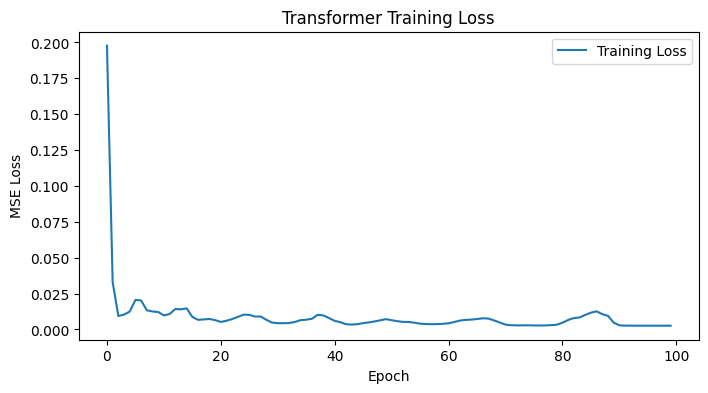

In [23]:
loss_list = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    loss_list.append(avg_loss)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

plt.figure(figsize=(8,4))
plt.plot(loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Transformer Training Loss')
plt.legend()
plt.show()

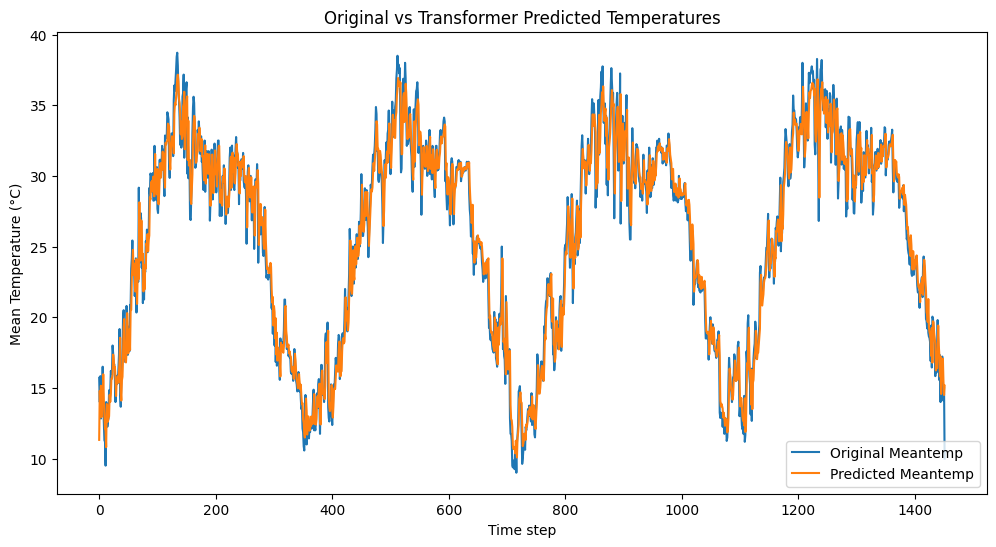

Transformer Training RMSE: 1.590 °C


In [24]:
model.eval()
with torch.no_grad():
    train_preds = model(X_train).cpu().numpy()
    y_train_np = y_train.cpu().numpy()

train_preds_original = scaler.inverse_transform(train_preds)
y_train_original = scaler.inverse_transform(y_train_np)

plt.figure(figsize=(12,6))
plt.plot(y_train_original, label='Original Meantemp')
plt.plot(train_preds_original, label='Predicted Meantemp')
plt.xlabel('Time step')
plt.ylabel('Mean Temperature (°C)')
plt.title('Original vs Transformer Predicted Temperatures')
plt.legend()
plt.show()

# Optional RMSE
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(y_train_original, train_preds_original))
print(f"Transformer Training RMSE: {rmse:.3f} °C")
